In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
import glob
import gc
from gan_utils import *

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
ngpu = 1
nz = 100
ngf = 64
ndf = 64
nc = 3
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print('device:', device)

device: cuda:0


In [3]:
image_paths = sorted(glob.glob("segmentation/image64/*.jpg"))
image_paths = [path for path in image_paths if path.find('image_')<0]
realdata = flower_dataset(image_paths, 
                          transform=transforms.Compose(
                              [transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
dataloader = DataLoader(realdata, batch_size=64, shuffle=True, num_workers=4)

100%|██████████| 25480/25480 [00:11<00:00, 2169.85it/s]


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4e5a3566d8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 345, in get
    return ForkingPickler.loads(res)
  File "/usr/local/lib/python3.5/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File

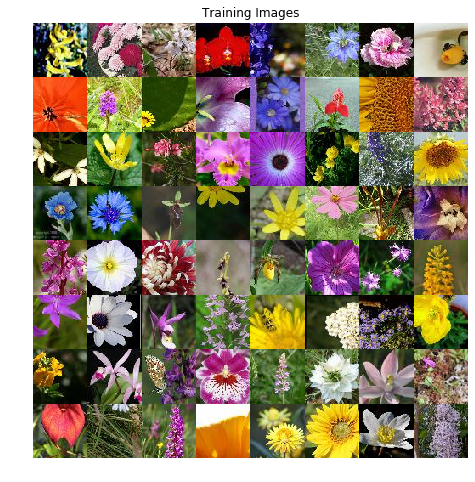

In [4]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0)))
plt.show()

In [5]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
    
    
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)
print("netG parameters:", [p.numel() for p in netG.parameters() if p.requires_grad])

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
netG parameters: [81

In [6]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            #in_channels, out_channels, kernel_size, stride=1, padding=0,
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)
print("netD parameters", [p.numel() for p in netD.parameters() if p.requires_grad])

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
netD parameters [3072, 131072, 128, 128, 524288, 2

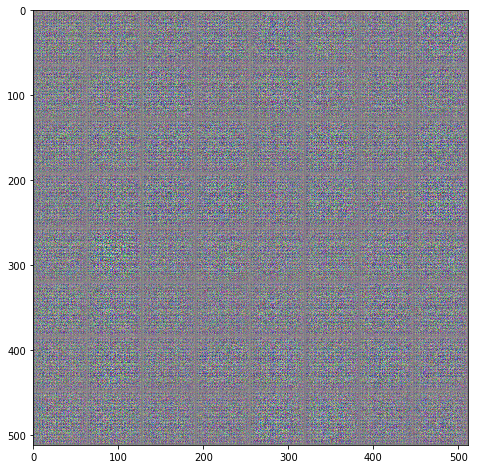

In [7]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
fake_image = netG(fixed_noise)
output = netD(fake_image)
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(vutils.make_grid(fake_image.detach(), padding=0, normalize=True).cpu(),(1,2,0)))
plt.show()

In [8]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

lr = 0.0002
beta1 = 0.5
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
!mkdir model_checkpoints
!mkdir sample_images
!mkdir sample_images/gan_z11

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 201
start_epoch = 0
n_update_G = 5

print("Starting Training Loop...")
# For each epoch
for epoch in range(start_epoch, start_epoch+num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        #real_cpu = data.to(device)
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        #label = get_label(b_size, real_label, soft=0.2, noise=True, noise_level=0.1, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        #label = get_label(b_size, fake_label, soft=0.2, noise=True, noise_level=0.1, device=device)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        #print("output1",output[:5])
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        #label = get_label(b_size, real_label, soft=0.2, noise=False, device=device)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 128 == 0:
            print('[%d/%d][%d/%d]  Loss_D: %.4f (%.4f / %.4f)  Loss_G: %.4f  D(x): %.4f  D(G(z)): %.4f / %.4f'
                  % (epoch, start_epoch+num_epochs, i, len(dataloader),
                     errD.item(), errD_real.item(), errD_fake.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            Ggradnorm_first = list(netG.parameters())[0].grad.norm()
            Ggradnorm_last = list(netG.parameters())[-1].grad.norm()
            print("Ggradnorm first: %.4f\t Ggradnormlast: %.4f"%(Ggradnorm_first, Ggradnorm_last))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == start_epoch+num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            image_tensor = vutils.make_grid(fake, padding=2, normalize=True)
            img_list.append(image_tensor)
            filepath = 'sample_images/gan_z11/ep'+str(epoch)+'_itr'+str(i)+'.jpg'
            io.imsave(filepath, image_tensor.numpy().transpose(1,2,0))

        iters += 1
        
    if epoch%20==0:
        checkpoint_path = "model_checkpoints/GAN_z11_ep"+str(epoch)
        print('save model to %s'%checkpoint_path)
        torch.save({
            'netG_state_dict': netG.state_dict(),
            'netD_state_dict': netD.state_dict(),
            'optimizerG_state_dict': optimizerG.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
            }, checkpoint_path)
        
print('Done')

mkdir: cannot create directory ‘model_checkpoints’: File exists
mkdir: cannot create directory ‘sample_images’: File exists
mkdir: cannot create directory ‘sample_images/gan_z11’: File exists
Starting Training Loop...
[0/201][0/399]  Loss_D: 1.7314 (0.7431 / 0.9883)  Loss_G: 5.9603  D(x): 0.5352  D(G(z)): 0.5669 / 0.0040
Ggradnorm first: 17.4128	 Ggradnormlast: 20.1692


/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


[0/201][128/399]  Loss_D: 0.2360 (0.2280 / 0.0081)  Loss_G: 5.5254  D(x): 0.8486  D(G(z)): 0.0080 / 0.0062
Ggradnorm first: 5.2018	 Ggradnormlast: 36.1458
[0/201][256/399]  Loss_D: 0.2081 (0.1585 / 0.0496)  Loss_G: 5.0622  D(x): 0.9041  D(G(z)): 0.0480 / 0.0087
Ggradnorm first: 3.5019	 Ggradnormlast: 31.3126
[0/201][384/399]  Loss_D: 0.1300 (0.0586 / 0.0715)  Loss_G: 4.3541  D(x): 0.9481  D(G(z)): 0.0673 / 0.0184
Ggradnorm first: 5.8079	 Ggradnormlast: 29.0485
save model to model_checkpoints/GAN_z11_ep0
[1/201][0/399]  Loss_D: 0.4025 (0.2300 / 0.1725)  Loss_G: 5.0230  D(x): 0.8275  D(G(z)): 0.1417 / 0.0131
Ggradnorm first: 6.1674	 Ggradnormlast: 56.8888
[1/201][128/399]  Loss_D: 2.5881 (0.0027 / 2.5854)  Loss_G: 13.3358  D(x): 0.9973  D(G(z)): 0.8562 / 0.0000
Ggradnorm first: 6.2097	 Ggradnormlast: 39.8688
[1/201][256/399]  Loss_D: 0.1461 (0.1172 / 0.0289)  Loss_G: 4.1119  D(x): 0.9002  D(G(z)): 0.0282 / 0.0219
Ggradnorm first: 4.8609	 Ggradnormlast: 25.2479
[1/201][384/399]  Loss_D: 0

[13/201][256/399]  Loss_D: 0.8336 (0.7816 / 0.0519)  Loss_G: 2.3390  D(x): 0.5499  D(G(z)): 0.0455 / 0.1641
Ggradnorm first: 4.9179	 Ggradnormlast: 34.1522
[13/201][384/399]  Loss_D: 0.6641 (0.6478 / 0.0163)  Loss_G: 2.3657  D(x): 0.5733  D(G(z)): 0.0159 / 0.1253
Ggradnorm first: 6.1798	 Ggradnormlast: 21.6967
[14/201][0/399]  Loss_D: 0.4441 (0.0232 / 0.4209)  Loss_G: 5.7717  D(x): 0.9783  D(G(z)): 0.2930 / 0.0052
Ggradnorm first: 6.7340	 Ggradnormlast: 40.7825
[14/201][128/399]  Loss_D: 0.5794 (0.0650 / 0.5143)  Loss_G: 5.2201  D(x): 0.9388  D(G(z)): 0.3592 / 0.0086
Ggradnorm first: 6.8029	 Ggradnormlast: 41.9355
[14/201][256/399]  Loss_D: 0.2351 (0.1770 / 0.0581)  Loss_G: 3.0477  D(x): 0.8575  D(G(z)): 0.0549 / 0.0646
Ggradnorm first: 6.8444	 Ggradnormlast: 24.4743
[14/201][384/399]  Loss_D: 0.3232 (0.2631 / 0.0601)  Loss_G: 3.1740  D(x): 0.7873  D(G(z)): 0.0559 / 0.0684
Ggradnorm first: 6.7876	 Ggradnormlast: 25.6689
[15/201][0/399]  Loss_D: 0.8990 (0.0112 / 0.8877)  Loss_G: 7.3609 

[26/201][384/399]  Loss_D: 0.2084 (0.0425 / 0.1659)  Loss_G: 3.8834  D(x): 0.9594  D(G(z)): 0.1423 / 0.0265
Ggradnorm first: 9.4648	 Ggradnormlast: 55.3275
[27/201][0/399]  Loss_D: 3.4788 (0.0004 / 3.4783)  Loss_G: 13.8322  D(x): 0.9996  D(G(z)): 0.9444 / 0.0000
Ggradnorm first: 7.4546	 Ggradnormlast: 41.8112
[27/201][128/399]  Loss_D: 0.1190 (0.0082 / 0.1108)  Loss_G: 4.6690  D(x): 0.9919  D(G(z)): 0.0970 / 0.0139
Ggradnorm first: 9.4019	 Ggradnormlast: 50.0872
[27/201][256/399]  Loss_D: 0.3141 (0.0087 / 0.3054)  Loss_G: 5.6721  D(x): 0.9914  D(G(z)): 0.2459 / 0.0050
Ggradnorm first: 8.6621	 Ggradnormlast: 34.4120
[27/201][384/399]  Loss_D: 0.2162 (0.0278 / 0.1884)  Loss_G: 5.4020  D(x): 0.9732  D(G(z)): 0.1609 / 0.0070
Ggradnorm first: 9.6138	 Ggradnormlast: 49.7212
[28/201][0/399]  Loss_D: 2.7021 (2.7018 / 0.0003)  Loss_G: 1.9293  D(x): 0.1431  D(G(z)): 0.0003 / 0.2470
Ggradnorm first: 6.0177	 Ggradnormlast: 53.2129
[28/201][128/399]  Loss_D: 0.0941 (0.0624 / 0.0317)  Loss_G: 5.2343

[40/201][0/399]  Loss_D: 5.4659 (0.0000 / 5.4659)  Loss_G: 11.3225  D(x): 1.0000  D(G(z)): 0.9898 / 0.0000
Ggradnorm first: 5.8103	 Ggradnormlast: 29.7811
[40/201][128/399]  Loss_D: 0.1549 (0.0747 / 0.0801)  Loss_G: 3.6625  D(x): 0.9305  D(G(z)): 0.0734 / 0.0335
Ggradnorm first: 11.3745	 Ggradnormlast: 50.2282
[40/201][256/399]  Loss_D: 0.1152 (0.0267 / 0.0885)  Loss_G: 4.9391  D(x): 0.9749  D(G(z)): 0.0816 / 0.0097
Ggradnorm first: 10.8795	 Ggradnormlast: 36.1687
[40/201][384/399]  Loss_D: 0.0930 (0.0265 / 0.0665)  Loss_G: 4.3688  D(x): 0.9745  D(G(z)): 0.0620 / 0.0209
Ggradnorm first: 9.9596	 Ggradnormlast: 28.1679
save model to model_checkpoints/GAN_z11_ep40
[41/201][0/399]  Loss_D: 0.1122 (0.0063 / 0.1059)  Loss_G: 5.3217  D(x): 0.9937  D(G(z)): 0.0958 / 0.0067
Ggradnorm first: 9.4528	 Ggradnormlast: 67.0522
[41/201][128/399]  Loss_D: 0.3942 (0.3580 / 0.0362)  Loss_G: 2.2467  D(x): 0.7497  D(G(z)): 0.0348 / 0.1616
Ggradnorm first: 7.5101	 Ggradnormlast: 35.2285
[41/201][256/399]  L

[53/201][128/399]  Loss_D: 0.1760 (0.0143 / 0.1617)  Loss_G: 4.1694  D(x): 0.9860  D(G(z)): 0.1392 / 0.0231
Ggradnorm first: 9.2302	 Ggradnormlast: 30.3815
[53/201][256/399]  Loss_D: 1.1139 (1.1136 / 0.0004)  Loss_G: 0.0933  D(x): 0.3885  D(G(z)): 0.0004 / 0.9161
Ggradnorm first: 1.1021	 Ggradnormlast: 15.0914
[53/201][384/399]  Loss_D: 0.0868 (0.0451 / 0.0417)  Loss_G: 4.3558  D(x): 0.9574  D(G(z)): 0.0401 / 0.0197
Ggradnorm first: 12.1955	 Ggradnormlast: 131.9711
[54/201][0/399]  Loss_D: 0.9805 (0.0021 / 0.9784)  Loss_G: 15.0873  D(x): 0.9979  D(G(z)): 0.5264 / 0.0000
Ggradnorm first: 8.6158	 Ggradnormlast: 62.2376
[54/201][128/399]  Loss_D: 2.4916 (0.5246 / 1.9670)  Loss_G: 1.6519  D(x): 0.7468  D(G(z)): 0.5385 / 0.3951
Ggradnorm first: 3.5473	 Ggradnormlast: 6.9709
[54/201][256/399]  Loss_D: 0.1949 (0.0340 / 0.1610)  Loss_G: 3.4793  D(x): 0.9679  D(G(z)): 0.1218 / 0.0587
Ggradnorm first: 9.5996	 Ggradnormlast: 41.1832
[54/201][384/399]  Loss_D: 0.0694 (0.0223 / 0.0471)  Loss_G: 4.5

[66/201][256/399]  Loss_D: 0.2789 (0.0510 / 0.2278)  Loss_G: 5.0674  D(x): 0.9528  D(G(z)): 0.1802 / 0.0091
Ggradnorm first: 10.2120	 Ggradnormlast: 31.1762
[66/201][384/399]  Loss_D: 0.0428 (0.0204 / 0.0225)  Loss_G: 5.2253  D(x): 0.9801  D(G(z)): 0.0218 / 0.0093
Ggradnorm first: 10.8081	 Ggradnormlast: 66.1805
[67/201][0/399]  Loss_D: 1.6272 (0.0000 / 1.6271)  Loss_G: 15.2577  D(x): 1.0000  D(G(z)): 0.6987 / 0.0000
Ggradnorm first: 7.5699	 Ggradnormlast: 42.6198
[67/201][128/399]  Loss_D: 0.0175 (0.0083 / 0.0092)  Loss_G: 6.7833  D(x): 0.9919  D(G(z)): 0.0090 / 0.0021
Ggradnorm first: 11.1674	 Ggradnormlast: 49.5424
[67/201][256/399]  Loss_D: 0.1768 (0.1619 / 0.0149)  Loss_G: 4.4336  D(x): 0.8641  D(G(z)): 0.0146 / 0.0226
Ggradnorm first: 8.0171	 Ggradnormlast: 39.2119
[67/201][384/399]  Loss_D: 0.0812 (0.0313 / 0.0498)  Loss_G: 5.3699  D(x): 0.9696  D(G(z)): 0.0470 / 0.0073
Ggradnorm first: 13.0319	 Ggradnormlast: 125.7700
[68/201][0/399]  Loss_D: 0.0793 (0.0163 / 0.0630)  Loss_G: 5

[79/201][384/399]  Loss_D: 0.0000 (0.0000 / 0.0000)  Loss_G: 48.0175  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
Ggradnorm first: 0.0000	 Ggradnormlast: 0.0000
[80/201][0/399]  Loss_D: 0.0000 (0.0000 / 0.0000)  Loss_G: 48.1122  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
Ggradnorm first: 0.0000	 Ggradnormlast: 0.0000
[80/201][128/399]  Loss_D: 0.0000 (0.0000 / 0.0000)  Loss_G: 47.7377  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
Ggradnorm first: 0.0000	 Ggradnormlast: 0.0000
[80/201][256/399]  Loss_D: 0.0000 (0.0000 / 0.0000)  Loss_G: 48.0685  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
Ggradnorm first: 0.0000	 Ggradnormlast: 0.0000
[80/201][384/399]  Loss_D: 0.0000 (0.0000 / 0.0000)  Loss_G: 47.6724  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
Ggradnorm first: 0.0000	 Ggradnormlast: 0.0000
save model to model_checkpoints/GAN_z11_ep80
[81/201][0/399]  Loss_D: 0.0000 (0.0000 / 0.0000)  Loss_G: 48.5682  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
Ggradnorm first: 0.0000	 Ggradnormlast: 0.0000
[81/201][128/399]  Loss

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
torch.save({
            'netG_state_dict': netG.state_dict(),
            'netD_state_dict': netD.state_dict(),
            'optimizerG_state_dict': optimizerG.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
            }, "model_checkpoints/GAN_z11")